# Alphalens Analysis

Due to version conflicts, `alphalens` does not work with the standard ml4t conda environment; please create a separate environment.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
import pandas as pd
from alphalens.tears import create_summary_tear_sheet, create_full_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

In [3]:
idx = pd.IndexSlice

## Load Data

In [4]:
with pd.HDFStore('data.h5') as store:
    lr_predictions = store['lr/predictions']
    lasso_predictions = store['lasso/predictions']
    lasso_scores = store['lasso/scores']
    ridge_predictions = store['ridge/predictions']
    ridge_scores = store['ridge/scores']

In [5]:
DATA_STORE = Path('..', 'data', 'assets.h5')

In [6]:
def get_trade_prices(tickers, start, stop):
    prices = (pd.read_hdf(DATA_STORE, 'quandl/wiki/prices').swaplevel().sort_index())
    prices.index.names = ['symbol', 'date']
    prices = prices.loc[idx[tickers, str(start):str(stop)], 'adj_open']
    return (prices
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [7]:
def get_best_alpha(scores):
    return scores.groupby('alpha').ic.mean().idxmax()

In [8]:
def get_factor(predictions):
    return (predictions.unstack('symbol')
            .dropna(how='all')
            .stack()
            .tz_localize('UTC', level='date')
            .sort_index())    

## Linear Regression

In [9]:
lr_factor = get_factor(lr_predictions.predicted.swaplevel())
lr_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.001839
                           AAPL     -0.001534
                           ABBV      0.001316
                           AGN       0.002175
                           AIG      -0.000336
dtype: float64

In [10]:
tickers = lr_factor.index.get_level_values('symbol').unique()

In [11]:
trade_prices = get_trade_prices(tickers, 2014, 2017)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1007 entries, 2014-01-02 to 2017-12-29
Columns: 257 entries, AAL to YUM
dtypes: float64(257)
memory usage: 2.0 MB


In [12]:
lr_factor_data = get_clean_factor_and_forward_returns(factor=lr_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))
lr_factor_data.info()

Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 73492 entries, (2014-12-09 00:00:00+00:00, AAL) to (2017-11-28 00:00:00+00:00, XOM)
Data columns (total 6 columns):
1D                 73492 non-null float64
5D                 73492 non-null float64
10D                73492 non-null float64
21D                73492 non-null float64
factor             73492 non-null float64
factor_quantile    73492 non-null float64
dtypes: float64(6)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.046824,0.008700,-0.003155,0.004055,14874,20.238938
2.0,-0.015561,0.010754,-0.000988,0.003358,14749,20.068851
3.0,-0.013413,0.012631,0.000142,0.003348,14247,19.385783
4.0,-0.011913,0.014850,0.001210,0.003459,14749,20.068851
5.0,-0.010072,0.038540,0.003306,0.004290,14873,20.237577


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.030,0.020,0.007,0.004
beta,-0.012,-0.081,-0.059,0.019
Mean Period Wise Return Top Quantile (bps),1.478,0.708,-0.098,0.224
Mean Period Wise Return Bottom Quantile (bps),-2.649,-0.698,-0.426,-0.599
Mean Period Wise Spread (bps),4.126,1.435,0.344,0.812


Information Analysis


,1D,5D,10D,21D
IC Mean,0.020,0.014,0.012,0.014
IC Std.,0.181,0.168,0.169,0.156
Risk-Adjusted IC,0.108,0.081,0.071,0.092
t-stat(IC),2.953,2.208,1.941,2.523
p-value(IC),0.003,0.028,0.053,0.012
IC Skew,0.022,-0.032,-0.068,-0.062
IC Kurtosis,-0.124,-0.190,-0.182,-0.256


Turnover Analysis


,10D,1D,21D,5D
Quantile 1 Mean Turnover,0.623,0.296,0.728,0.521
Quantile 2 Mean Turnover,0.761,0.516,0.788,0.708
Quantile 3 Mean Turnover,0.778,0.568,0.808,0.738
Quantile 4 Mean Turnover,0.756,0.515,0.783,0.706
Quantile 5 Mean Turnover,0.645,0.301,0.745,0.536


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.82,0.542,0.386,0.238


<Figure size 432x288 with 0 Axes>

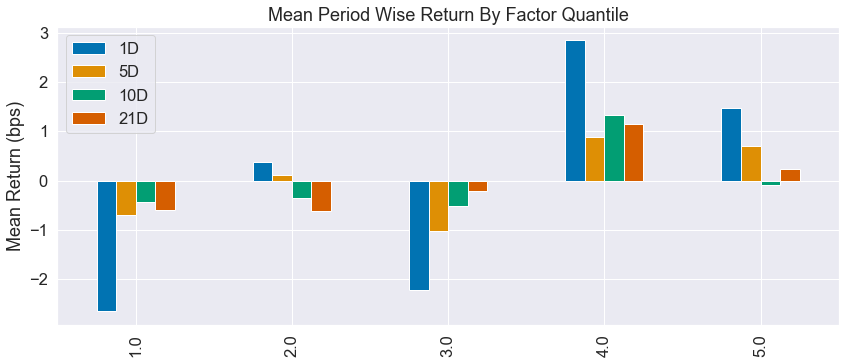

In [13]:
create_summary_tear_sheet(lr_factor_data);

## Ridge Regression

In [14]:
best_ridge_alpha = get_best_alpha(ridge_scores)
ridge_predictions = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha].drop('alpha', axis=1)

In [15]:
ridge_factor = get_factor(ridge_predictions.predicted.swaplevel())
ridge_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.001948
                           AAPL     -0.001526
                           ABBV      0.001099
                           AGN       0.001914
                           AIG      -0.000462
dtype: float64

In [16]:
ridge_factor_data = get_clean_factor_and_forward_returns(factor=ridge_factor,
                                                         prices=trade_prices,
                                                         quantiles=5,
                                                         periods=(1, 5, 10, 21))
ridge_factor_data.info()

Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 73492 entries, (2014-12-09 00:00:00+00:00, AAL) to (2017-11-28 00:00:00+00:00, XOM)
Data columns (total 6 columns):
1D                 73492 non-null float64
5D                 73492 non-null float64
10D                73492 non-null float64
21D                73492 non-null float64
factor             73492 non-null float64
factor_quantile    73492 non-null float64
dtypes: float64(6)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.035996,0.009161,-0.003350,0.003623,14874,20.238938
2.0,-0.013073,0.011246,-0.001325,0.003056,14749,20.068851
3.0,-0.010553,0.012706,-0.000255,0.003086,14247,19.385783
4.0,-0.009280,0.015166,0.000753,0.003221,14749,20.068851
5.0,-0.007696,0.038573,0.002703,0.004059,14873,20.237577


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.029,0.022,0.012,0.008
beta,-0.010,-0.083,-0.060,0.021
Mean Period Wise Return Top Quantile (bps),1.334,0.480,-0.200,0.115
Mean Period Wise Return Bottom Quantile (bps),-2.474,-1.313,-0.855,-0.979
Mean Period Wise Spread (bps),3.808,1.819,0.671,1.081


Information Analysis


,1D,5D,10D,21D
IC Mean,0.020,0.014,0.013,0.014
IC Std.,0.182,0.169,0.170,0.157
Risk-Adjusted IC,0.109,0.085,0.074,0.089
t-stat(IC),2.968,2.308,2.014,2.421
p-value(IC),0.003,0.021,0.044,0.016
IC Skew,0.016,-0.030,-0.080,-0.061
IC Kurtosis,-0.124,-0.178,-0.161,-0.245


Turnover Analysis


,10D,1D,21D,5D
Quantile 1 Mean Turnover,0.619,0.293,0.724,0.513
Quantile 2 Mean Turnover,0.756,0.507,0.788,0.701
Quantile 3 Mean Turnover,0.777,0.561,0.805,0.734
Quantile 4 Mean Turnover,0.752,0.510,0.784,0.699
Quantile 5 Mean Turnover,0.640,0.298,0.742,0.529


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.824,0.56,0.401,0.247


<Figure size 432x288 with 0 Axes>

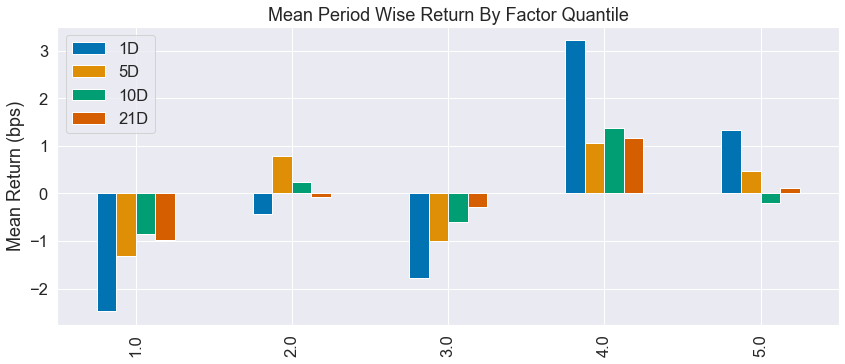

In [17]:
create_summary_tear_sheet(ridge_factor_data);

## Lasso Regression

In [18]:
best_lasso_alpha = get_best_alpha(lasso_scores)
lasso_predictions = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha].drop('alpha', axis=1)

In [19]:
lasso_factor = get_factor(lasso_predictions.predicted.swaplevel())
lasso_factor.head()

date                       symbol
2014-12-09 00:00:00+00:00  AAL       0.001875
                           AAPL     -0.001646
                           ABBV      0.001164
                           AGN       0.001919
                           AIG      -0.000529
dtype: float64

In [20]:
lasso_factor_data = get_clean_factor_and_forward_returns(factor=lasso_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))
lasso_factor_data.info()

Dropped 0.8% entries from factor data: 0.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 73492 entries, (2014-12-09 00:00:00+00:00, AAL) to (2017-11-28 00:00:00+00:00, XOM)
Data columns (total 6 columns):
1D                 73492 non-null float64
5D                 73492 non-null float64
10D                73492 non-null float64
21D                73492 non-null float64
factor             73492 non-null float64
factor_quantile    73492 non-null float64
dtypes: float64(6)
memory usage: 3.7+ MB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.044249,0.009401,-0.003444,0.003813,14874,20.238938
2.0,-0.013901,0.011329,-0.001349,0.003222,14749,20.068851
3.0,-0.012216,0.013095,-0.000246,0.003274,14247,19.385783
4.0,-0.010771,0.015355,0.000791,0.003428,14749,20.068851
5.0,-0.008964,0.038336,0.002822,0.004332,14873,20.237577


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.030,0.021,0.009,0.006
beta,-0.011,-0.081,-0.057,0.020
Mean Period Wise Return Top Quantile (bps),1.852,0.685,-0.113,0.217
Mean Period Wise Return Bottom Quantile (bps),-2.543,-0.852,-0.632,-0.817
Mean Period Wise Spread (bps),4.395,1.564,0.532,1.021


Information Analysis


,1D,5D,10D,21D
IC Mean,0.020,0.014,0.012,0.015
IC Std.,0.182,0.169,0.170,0.157
Risk-Adjusted IC,0.109,0.082,0.070,0.093
t-stat(IC),2.973,2.243,1.900,2.533
p-value(IC),0.003,0.025,0.058,0.012
IC Skew,0.019,-0.025,-0.069,-0.054
IC Kurtosis,-0.136,-0.191,-0.186,-0.277


Turnover Analysis


,10D,1D,21D,5D
Quantile 1 Mean Turnover,0.621,0.296,0.728,0.519
Quantile 2 Mean Turnover,0.757,0.512,0.791,0.704
Quantile 3 Mean Turnover,0.781,0.564,0.806,0.734
Quantile 4 Mean Turnover,0.753,0.508,0.783,0.699
Quantile 5 Mean Turnover,0.643,0.299,0.745,0.534


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.822,0.548,0.391,0.238


<Figure size 432x288 with 0 Axes>

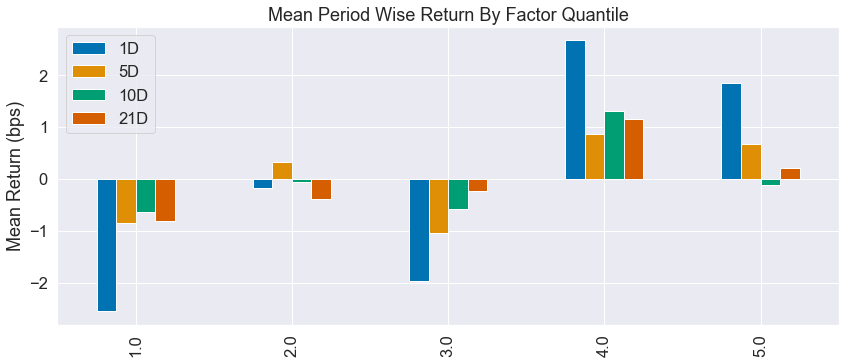

In [21]:
create_summary_tear_sheet(lasso_factor_data);